# Disclaimer
***
This project was conducted for University of Toronto - School of Continuing Studies (SCS) as part of the Intelligent Agents & Reinforcement Learning - 3547 Course.
***
**Project Title:** Safe Landings In Deep Space<br><br>
**Team Members:** Adnan Lanewala, Nareshkumar Patel, Nisarg Patel<br><br>
**Course:** UFT 3547 - Intelligent Agents & Reinforcement Learning<br><br>
**Instructor:** Larry Simon<br><br>
**Session:** December 2019<br><br>
**Open AI Gym Environment:** https://github.com/openai/gym<br><br>
**Lunar Lander:** http://gym.openai.com/envs/LunarLander-v2/<br><br>
**DQN Algorith Reference:** https://arxiv.org/pdf/1312.5602.pdf

# Import All Dependencies
***

In [1]:
### IMPORT ALL LIBRARIES AND FUNCTIONS TO BE USED ###
import gym # Lunar Lander environment
import numpy as np # array
from collections import deque # memory
import random # For randomization
import os # For directory manipulations
import matplotlib.pyplot as plt # for plotting

### KERAS IMPORTS FOR NEURAL NETWORK ###
import keras
from keras.utils import plot_model
from keras import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Model, load_model

Using TensorFlow backend.


In [2]:
print("Gym version:",gym.__version__) # Print GYM VERSION and ensure its > 0.15.4
print("Keras version:",keras.__version__) # Print GYM VERSION and ensure its > 0.15.4

Gym version: 0.15.4
Keras version: 2.2.5


# Setup
***

In [3]:
# Setup Paths for saving and loading weights
ROOT_PATH = os.getcwd()
WEIGHTS_PATH = os.path.join(ROOT_PATH,"modelweights")
ASSETS_PATH = os.path.join(ROOT_PATH,"assets")

print("Root Path:",ROOT_PATH)
print("Weights Path:",WEIGHTS_PATH)
print("Assets Path:",ASSETS_PATH)    

Root Path: C:\Users\Admin\Documents\UFT AI\Final Project RL
Weights Path: C:\Users\Admin\Documents\UFT AI\Final Project RL\modelweights
Assets Path: C:\Users\Admin\Documents\UFT AI\Final Project RL\assets


# Q-Learning
***

In [4]:
# This class implements a Deep Q-Learning Algorithm using Keras Neural Network
class LunarLanderDQNAgent:

    # This function initializes the LunarLanderDQNAgent class when its called
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=500000) # memory buffer
        self.after_time_steps_update_weights = 100 # after how many time steps should the weights in the target network be updated
        
        # Hyper-parameters
        
        # discount rate. If small then the agent looks for immediate reward. 
        # If big then the agent looks for long term reward
        self.gamma = 0.99
        
        # how fast an agent learns
        self.learning_rate = 0.001 # learning rate
        
        # exploration parameter
        self.epsilon = 1.0 # exploration rate
        self.epsilon_min = 0.01 # minimum exploration probability
        self.epsilon_decay = 0.997 # exponential decay rate for exploration probability
    
        # builds a keras model       
        self.policy_network = self.build_keras_model() # policy network
        self.target_network = self.build_keras_model() # target network

        
    # This function creates a neural network using keras library for Deep Q-Learning model
    def build_keras_model(self):
        model = Sequential() # we will create a sequential model

        # 1st Layer: Input Layer with State Size = 8 and Hidden layer with 100 nodes
        model.add(Dense(100, input_dim = self.state_size, activation = "relu", name = "Input_Layer"))

        # 2nd layer: Hidden layer with 50 nodes
        model.add(Dense(50, activation = "relu", name = "Hidden_Layer"))

        # 3rd Layer: Output Layer with dimensions of the # of actions = 4
        model.add(Dense(self.action_size, activation="linear", name = "Output_Layer"))

        # Compile the model
        # Loss function is Mean Square Error
        # Optimizer is Adam
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        
        # Plot the keras model
        if(os.path.exists(os.path.join(ASSETS_PATH,"kerasmodel.png"))): # if the file already exists delete it and overwrite it
            print("Overwriting the existing kerasmodel.png file")
            os.remove(os.path.join(ASSETS_PATH,"kerasmodel.png")) # delete the file so we can overwrite it
            
        plot_model(model, to_file = os.path.join(ASSETS_PATH,"kerasmodel.png"), show_shapes=True, show_layer_names=True) # save the plot
        
        model.summary() # Print Model Summary
        return model # return the keras model
    
    # This function will store states, actions, and resulting rewards inside the memory buffer
    def add_to_memory(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) # add to the memory buffer
    
    # This function will train the neural network with experiences that are stored in the agents memory
    def replay_memory(self, batch_size):

        # use the random sample from the memory
        minibatch = random.sample(self.memory, batch_size)
        
        # extract state, action, reward, next_state and done from the minibatch
        state_list = np.array([i[0] for i in minibatch])
        action_list = np.array([i[1] for i in minibatch])
        reward_list = np.array([i[2] for i in minibatch])
        next_state_list = np.array([i[3] for i in minibatch])
        done_list = np.array([i[4] for i in minibatch])

        # reshape array
        state_list = np.squeeze(state_list)
        next_state_list = np.squeeze(next_state_list)
        
        # future discounted reward prediction from the bellman's equation
        targets = reward_list + self.gamma * (np.amax(self.target_network.predict_on_batch(next_state_list), axis=1)) * (1 - done_list)

        # approximate the current state to future discounted reward
        # once we have q* function in this case targets, we can determine the optimal
        # policy by applying reinforcement learning to find the action that maximizes q* for each state
        targets_full = self.policy_network.predict_on_batch(state_list)
        ind = np.array([i for i in range(batch_size)])
        targets_full[[ind], [action_list]] = targets
        
        # train our neural network with the state and targets_full
        # policy network
        self.policy_network.fit(state_list, targets_full, epochs=1, verbose=0)
        
        # decay our epsilon until you hit the minimum epsilon 
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
    # This function will return an action that an agent should take 
    # based on the state and epsilon value(exploration vs exploitation)
    def get_action(self,state):
        # action is selected through exploration or exploitation (epsilon or epsilon greedy)
        
        # exploration
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size) # agent acts randomly

        predicted_reward = self.policy_network.predict(state) # predict the reward value based on a given state
        
        return np.argmax(predicted_reward[0]) # pick an action based on the predicted reward

# Plot Function
***

In [5]:
# This functions creates a plot given the x and y values along with other parameters
def create_plot(x_values, y_values, x_label, y_label, title, save_fig, fname):
    plt.plot(x_values, y_values) # create a plot
    plt.xlabel(x_label) # label the x-axis
    plt.ylabel(y_label) # label the y-axis
    plt.title(title) # set the title
    
    if (save_fig): # save the plot if the user wants it
        plt.savefig(os.path.join(fname))
    
    return plt # return the plot

# AI Agent Training
***
This is the main training method. Below are the steps for this method:<br>

1. Initialize the agent (policy network and target network)<br>
2. For each episode:<br>
A. Initialize the starting state<br>
B. Select an action through exploration or exploitation<br>
C.Execute selected action<br>
D.Store expierence in replay memory<br>
E. Sample random batch from replay memory<br>
F. Pass batch of preprocessed states to policy and target network<br>
G. Calculate loss between output Q-values and target Q-values<br>
H. Gradient descent updates weights in the policy<br>
I. After x time steps weights in the target network are updated to the weights in the policy network<br>

In [6]:
# This function carries out the training process for the agent
def train_agent(env, STATE_SIZE, ACTION_SIZE, MAX_STEPS, MAX_EPISODES):
    print("*********************************************************")
    print("Agent Training Started")
    print("*********************************************************")
    agent = LunarLanderDQNAgent(STATE_SIZE, ACTION_SIZE)
    done = False
    batch_size = 64
    score_history_per_episode = []
    counter = 0
    score_threshold = 50 # minimum score the agent should get in the last 100 moves
    
    for episode in range(MAX_EPISODES):
        
        # reset the environment
        state = env.reset()
        
        # reshape the state array
        state = np.reshape(state, [1, STATE_SIZE])
        
        # clear the score
        score = 0
        
        for step in range(MAX_STEPS): # iterate through steps
            env.render() # show it on the environment
            
            # ask the agent what action to take given the current state
            action_to_take = agent.get_action(state)
            
            # take the action and extract the next_state, reward, done and info
            next_state, reward, done, info = env.step(action_to_take) # take action and get results
            
            # update our score
            score = score + reward
            
            # next state array creation
            next_state = np.reshape(next_state, [1, STATE_SIZE])
            
            # add to the agents memory buffer
            agent.add_to_memory(state, action_to_take, reward, next_state, done)
            
            # update the current state to the next state to indicate that the state has changed
            state = next_state
            
            counter += 1
            
            if len(agent.memory) > batch_size:
                agent.replay_memory(batch_size)
            
            if done:
                print("==============================================================")
                print("Episode: {}/{} Score: {} Epsilon: {}".format(episode+1, MAX_EPISODES, score, agent.epsilon))
                print("==============================================================")
                break
            
            # we have to update the weights of the target networks after certain
            # step size
            if agent.after_time_steps_update_weights == counter:
                modelsweights = np.array(agent.policy_network.get_weights())
                clonemodel_weights = np.array(agent.target_network.get_weights())
                agent.target_network.set_weights(modelsweights)
                counter = 0
                agent.policy_network.save(os.path.join(WEIGHTS_PATH,"LunarLander.h5"))
        
        # At every 50 episodes during the training process save the model
        if ((episode % 50) == 0) and (episode >= 50):
            print("Saving Model ....................")
            agent.policy_network.save(os.path.join(WEIGHTS_PATH,"LunarLander.h5"))
            
        # add score to the list so we have a track of score per episode
        score_history_per_episode.append(score) 
        
        # Below we will do early stopping of our model to prevent overfitting
        # if the last 100 score is more than 50 then we stop training
        # Average score of last 100 episode
        average_score = np.mean(score_history_per_episode[-100:])
        if average_score > score_threshold:
            print('\n Training Task Completed Early! \n')
            agent.policy_network.save(os.path.join(WEIGHTS_PATH,"LunarLander.h5")) # save the final model
            env.close() # close the environment
            break
        print("Average Score over the last 100 episode: {0:.2f} \n".format(average_score))
    
    return score_history_per_episode

# AI Agent Testing
***

In [7]:
# This function carries out the testing process for the agent once its trained
def test_agent(env, STATE_SIZE, ACTION_SIZE, MAX_STEPS, MAX_EPISODES, model):
    print("*********************************************************")
    print("Agent Testing Started")
    print("*********************************************************")
    agent = LunarLanderDQNAgent(STATE_SIZE, ACTION_SIZE)

    # Load Pre-trained model into the policy and the target network
    agent.policy_network = load_model(model)
    agent.target_network = load_model(model)
    
    done = False
    batch_size = 64
    score_history_per_episode = []
    
    for episode in range(MAX_EPISODES):
        
        # reset the environment
        state = env.reset()
        
        # reshape the state array
        state = np.reshape(state, [1, STATE_SIZE])
        
        # clear the score
        score = 0
        
        for step in range(MAX_STEPS): # iterate through steps
            env.render() # show it on the environment
            
            # ask the agent what action to take given the current state
            action_to_take = agent.get_action(state)
            
            # take the action and extract the next_state, reward, done and info
            next_state, reward, done, info = env.step(action_to_take) # take action and get results
            
            # update our score
            score = score + reward
            
            # next state array creation
            next_state = np.reshape(next_state, [1, STATE_SIZE])
            
            # add to the agents memory buffer
            agent.add_to_memory(state, action_to_take, reward, next_state, done)
            
            # update the current state to the next state to indicate that the state has changed
            state = next_state
            
            if len(agent.memory) > batch_size:
                agent.replay_memory(batch_size)
            
            if done:
                print("==============================================================")
                print("Episode: {}/{} Score: {}".format(episode+1, MAX_EPISODES, score))
                print("==============================================================")
                break
        
        # add score to the list so we have a track of score per episode
        score_history_per_episode.append(score) 
        
        # Average score of last 100 episode
        average_score = np.mean(score_history_per_episode[-100:])
        print("Average Score over the last 100 episode: {0:.2f} \n".format(average_score))
        
    print("Agent Test Completed")
    env.close() # close the environment
    return score_history_per_episode

# Main
***

Action Space: 4
Observation Space: 8
*********************************************************
Agent Training Started
*********************************************************




Overwriting the existing kerasmodel.png file
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (Dense)          (None, 100)               900       
_________________________________________________________________
Hidden_Layer (Dense)         (None, 50)                5050      
_________________________________________________________________
Output_Layer (Dense)         (None, 4)                 204       
Total params: 6,154
Trainable params: 6,154
Non-trainable params: 0
_________________________________________________________________
Overwriting the existing kerasmodel.png file
Model: "sequential_2"
_________________________________________________________________
Layer (type)            

Episode: 18/500 Score: -76.28542268978141 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: -192.54 

Episode: 19/500 Score: -39.685998514605096 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: -184.50 

Episode: 20/500 Score: -324.31732559636373 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: -191.49 

Episode: 21/500 Score: -366.26186109662757 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: -199.81 

Episode: 22/500 Score: -162.67752998271126 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: -198.12 

Episode: 23/500 Score: -207.44408050467376 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: -198.53 

Episode: 24/500 Score: -182.677938354548 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: -197.87 

Episode: 25/500 Score: -151.22661258102983 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: -196.00 

Episode: 26/500 Sco

Episode: 51/500 Score: 6.081414107447225 Epsilon: 0.00999258133189499
Saving Model ....................
Average Score over the last 100 episode: -140.15 

Episode: 52/500 Score: -95.20407700600359 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: -139.29 

Episode: 53/500 Score: -90.4201927017768 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: -138.37 

Episode: 54/500 Score: -87.22052656430867 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: -137.42 

Episode: 55/500 Score: -21.292428633541114 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: -135.31 

Episode: 56/500 Score: -73.16970017382017 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: -134.20 

Episode: 57/500 Score: 74.1921563356567 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: -130.54 

Episode: 58/500 Score: -67.75826011134122 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: -12

Episode: 84/500 Score: -83.25375804018493 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: -103.69 

Episode: 85/500 Score: -77.06518583866075 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: -103.38 

Episode: 86/500 Score: -123.54432218133624 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: -103.61 

Episode: 87/500 Score: -80.32881756565044 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: -103.35 

Episode: 88/500 Score: -41.78680731352819 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: -102.65 

Episode: 89/500 Score: -22.299902561989608 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: -101.74 

Episode: 90/500 Score: -23.041791949362178 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: -100.87 

Episode: 91/500 Score: -38.58020265710156 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: -100.19 

Episode: 92/500 Score

Episode: 117/500 Score: -38.97775577842339 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: -67.93 

Episode: 118/500 Score: -27.81531979573906 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: -67.44 

Episode: 119/500 Score: -34.63890310057827 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: -67.39 

Episode: 120/500 Score: -21.205488837150305 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: -64.36 

Episode: 121/500 Score: -37.20500110117931 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: -61.07 

Episode: 122/500 Score: -33.369089611745515 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: -59.78 

Episode: 123/500 Score: -73.7865259296593 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: -58.44 

Episode: 124/500 Score: -19.152008440569396 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: -56.81 

Episode: 125/500 Score

Episode: 151/500 Score: -91.28235222403941 Epsilon: 0.00999258133189499
Saving Model ....................
Average Score over the last 100 episode: -28.20 

Episode: 152/500 Score: -124.60011499226783 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: -28.49 

Episode: 153/500 Score: -166.23726260159114 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: -29.25 

Episode: 154/500 Score: 161.81106699929342 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: -26.76 

Episode: 155/500 Score: -33.28886252925975 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: -26.88 

Episode: 156/500 Score: -42.85626088058166 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: -26.58 

Episode: 157/500 Score: 243.3524197114818 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: -24.89 

Episode: 158/500 Score: 234.82070905588316 Epsilon: 0.00999258133189499
Average Score over the last 100 episode

Episode: 185/500 Score: 258.5248505981008 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: 23.02 

Episode: 186/500 Score: 266.77170573730075 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: 26.92 

Episode: 187/500 Score: 269.7266344512673 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: 30.42 

Episode: 188/500 Score: 225.5588366316592 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: 33.10 

Episode: 189/500 Score: 253.1299475322303 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: 35.85 

Episode: 190/500 Score: 247.03731548856217 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: 38.55 

Episode: 191/500 Score: 15.745685975658034 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: 39.10 

Episode: 192/500 Score: 281.4995414053776 Epsilon: 0.00999258133189499
Average Score over the last 100 episode: 42.24 

Episode: 193/500 Score: 227.595197026

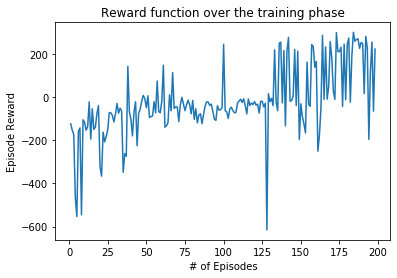

In [8]:
if __name__ == "__main__":
    
    # Number of steps per given episode
    MAX_STEPS = 2000

    # Maximum number of episodes for training
    MAX_EPISODES = 500

    env = gym.make('LunarLander-v2')
    env.seed(0)
    np.random.seed(0)

    # Get Action Size from the Action Space
    ACTION_SIZE = env.action_space.n # 4 discrete action (Do nothing, fire left engine, fire main engine, fire right engine)
    print("Action Space:", ACTION_SIZE)

    # Get State Size from the Observation Space
    STATE_SIZE = env.observation_space.shape[0]
    print("Observation Space:", STATE_SIZE)
    
    # First we will train the agent
    training_score_history = train_agent(env, STATE_SIZE, ACTION_SIZE, MAX_STEPS, MAX_EPISODES)
    
    # Create a plot to see the agent's training process
    x_values = range(1,len(training_score_history)+1)
    x_axis = '# of Episodes'
    y_axis = 'Episode Reward'
    plot_title = 'Reward function over the training phase'
    save_figure = True
    plot_save_path = os.path.join(ASSETS_PATH,"training_plot.png")
    train_plot = create_plot(x_values, training_score_history, x_axis, y_axis, plot_title, save_figure, plot_save_path)
    train_plot.show()

*********************************************************
Agent Testing Started
*********************************************************
Overwriting the existing kerasmodel.png file
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (Dense)          (None, 100)               900       
_________________________________________________________________
Hidden_Layer (Dense)         (None, 50)                5050      
_________________________________________________________________
Output_Layer (Dense)         (None, 4)                 204       
Total params: 6,154
Trainable params: 6,154
Non-trainable params: 0
_________________________________________________________________
Overwriting the existing kerasmodel.png file
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   


Episode: 31/100 Score: -41.3550970628444
Average Score over the last 100 episode: -102.94 

Episode: 32/100 Score: -3.57567453937277
Average Score over the last 100 episode: -99.84 

Episode: 33/100 Score: 216.1850032523356
Average Score over the last 100 episode: -90.26 

Episode: 34/100 Score: -84.21738975548975
Average Score over the last 100 episode: -90.08 

Episode: 35/100 Score: -34.69098916126319
Average Score over the last 100 episode: -88.50 

Episode: 36/100 Score: -139.93454795552822
Average Score over the last 100 episode: -89.93 

Episode: 37/100 Score: -317.6241873233797
Average Score over the last 100 episode: -96.08 

Episode: 38/100 Score: -107.76775925781695
Average Score over the last 100 episode: -96.39 

Episode: 39/100 Score: 55.10705973238939
Average Score over the last 100 episode: -92.51 

Episode: 40/100 Score: -9.152173828646909
Average Score over the last 100 episode: -90.42 

Episode: 41/100 Score: 199.4957169131198
Average Score over the last 100 episode:

Episode: 69/100 Score: 237.524361611421
Average Score over the last 100 episode: 7.10 

Episode: 70/100 Score: 144.91680008859637
Average Score over the last 100 episode: 9.07 

Episode: 71/100 Score: 256.4598192960033
Average Score over the last 100 episode: 12.55 

Episode: 72/100 Score: 253.99942028881185
Average Score over the last 100 episode: 15.91 

Episode: 73/100 Score: 195.20728792428585
Average Score over the last 100 episode: 18.36 

Episode: 74/100 Score: -93.9321904426573
Average Score over the last 100 episode: 16.84 

Episode: 75/100 Score: -35.57794069850053
Average Score over the last 100 episode: 16.15 

Episode: 76/100 Score: -139.76764155156712
Average Score over the last 100 episode: 14.09 

Episode: 77/100 Score: 10.885533907918514
Average Score over the last 100 episode: 14.05 

Episode: 78/100 Score: 191.3847572182201
Average Score over the last 100 episode: 16.33 

Episode: 79/100 Score: -224.41680983202139
Average Score over the last 100 episode: 13.28 

Epis

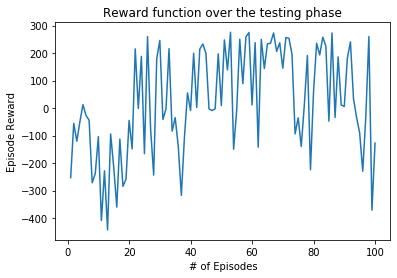

In [9]:
    env = gym.make('LunarLander-v2')
    env.seed(0)
    np.random.seed(0)
    
    # Now we will test the trained agent
    TEST_MAX_STEPS = 2000
    TEST_MAX_EPISODES = 100
    FINAL_TRAINED_MODEL = os.path.join(WEIGHTS_PATH,"LunarLander.h5")
    test_score_history = test_agent(env, STATE_SIZE, ACTION_SIZE, TEST_MAX_STEPS, TEST_MAX_EPISODES, FINAL_TRAINED_MODEL)
    
    # Create a plot to see the agent's testing process
    x_values = range(1,len(test_score_history)+1)
    x_axis = '# of Episodes'
    y_axis = 'Episode Reward'
    plot_title = 'Reward function over the testing phase'
    save_figure = True
    plot_save_path = os.path.join(ASSETS_PATH,"testing_plot.png")
    test_plot = create_plot(x_values, test_score_history, x_axis, y_axis, plot_title, save_figure, plot_save_path)
    test_plot.show()
    
    #env.close() # close the environment

# Conclusion
***

Including the target network does help our agent.<br>
As we can see that our agent learned to land after around `200 episodes`. If the average `score` threshold is increased to `100` then we would have seen that our agent would have learned to land even better.